In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
def face_detection(image):
    #cv2.imshow('2',image)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haar_classifier = cv2.CascadeClassifier('opencv/data/haarcascades/haarcascade_frontalface_default.xml')
    face = haar_classifier.detectMultiScale(image_gray, scaleFactor=1.3, minNeighbors=7)
    print(face)
    (x,y,w,h) = face[0]
    return image_gray[y:y+w, x:x+h], face[0]

In [3]:
def get_lbp_hist(grayscale_img):
    
    dim = grayscale_img.shape
    
    lbp = np.zeros(256)
    
    num1=num2=0
    
    
    #print(grayscale_img.shape)
    for i in range(1,dim[0]-1):
        for j in range(1,dim[1]-1):
            
            num1+=1
            binary = ""
            if grayscale_img[i][j] < grayscale_img[i-1][j-1]:
                binary+='1'
            else:
                binary+='0'
                
            if grayscale_img[i][j] < grayscale_img[i-1][j]:
                binary+='1'
            else:
                binary+='0'
                
            if grayscale_img[i][j] < grayscale_img[i-1][j+1]:
                binary+='1'
            else:
                binary+='0'
                
            if grayscale_img[i][j] < grayscale_img[i][j+1]:
                binary+='1'
            else:
                binary+='0'
                
            if grayscale_img[i][j] < grayscale_img[i+1][j+1]:
                binary+='1'
            else:
                binary+='0'
                
            if grayscale_img[i][j] < grayscale_img[i+1][j]:
                binary+='1'
            else:
                binary+='0'
                
            if grayscale_img[i][j] < grayscale_img[i+1][j-1]:
                binary+='1'
            else:
                binary+='0'
                
            if grayscale_img[i][j] < grayscale_img[i][j-1]:
                binary+='1'
            else:
                binary+='0'
                
            
            transitions = 0
            
            for k in range(1,len(binary)):
                if binary[k] != binary[k-1]:
                    transitions +=1
            
            if transitions  > 2: 
                continue
                
            num2+=1
            
            binary = int(binary,2)
            lbp[binary]+=1
    
    #print(num1)
    #print(num2)
    return lbp # <LBP histogram which is a list of 256 numbers>

In [4]:
def segment_img(img):
    patch_width  = 5
    patch_height = 5
    dim = img.shape
    
    histograms = []
    num = 0
    
    print(img.shape)
    for x in range(0,dim[0],patch_width):
        for y in range(0,dim[1],patch_height):
            
            
            if(patch_width+x >= dim[0] or patch_width+y >= dim[1] ):
                continue
            num+=1 
            patch = img[x:x+patch_width,y:y+patch_height]
    
            histogram = get_lbp_hist(patch)
            histograms.append(histogram)
    
    histo = np.zeros(256)
    
    for h in histograms:
        for i in range(len(h)):
            histo[i] += h[i]
        
        
    print(num)
    return histo

[[344 158 134 134]
 [784 182 140 140]
 [570 184 130 130]]
(140, 140)
729
(140, 130)
675
[324.  46.  38.  35.  54.   0.  70. 128.  30.   0.   0.   0.  45.   0.
 209. 254.  47.   0.   0.   0.   0.   0.   0.   0.  54.   0.   0.   0.
 129.   0. 285.  49.  47.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.  70.   0.   0.   0.   0.   0.   0.   0.
 199.   0.   0.   0. 343.   0.  82.  26.  53.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  66.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 156.   0.   0.   0.   0.   0.   0.   0. 303.   0.   0.   0.  63.   0.
  19.  10.  41.  65.   0. 194.   0.   0.   0. 246.   0.   0.   0.   0.
   0.   0.   0.  78.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.  19.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

(array([199.,   3.,   1.,   4.,   0.,   3.,   6.,   5.,   4.,   3.,   1.,
          2.,   2.,   2.,   0.,   2.,   2.,   1.,   0.,   1.,   1.,   0.,
          0.,   1.,   0.,   1.,   0.,   1.,   2.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

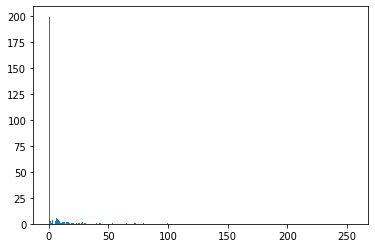

In [8]:
img = cv2.imread('a.jpg')

image = cv2.cvtColor(img[158:153+134,344:344+134], cv2.COLOR_BGR2GRAY)
image2 = cv2.cvtColor(img[182:182+140,784:784+140], cv2.COLOR_BGR2GRAY)
image3 = cv2.cvtColor(img[184:184+140,570:570+130], cv2.COLOR_BGR2GRAY)



face_detection(img)
#img =  cv2.rectangle(img, (570,184), (570+130,184+140), (255, 0, 0) , 2)


'''
# Just For Testing the image
image = cv2.cvtColor(img[184:184+140,570:570+130], cv2.COLOR_BGR2GRAY)
#print(image.shape)
cv2.imshow('xxx',image)
cv2.waitKey(0)
cv2.destroyAllWindows()
#=======================================================================
'''

hist = segment_img(image2)
hist2 = segment_img(image3)

hist3 = np.zeros(256)
for i in range(256):
    hist3[i] = abs(hist[i] - hist2[i])
    
#hist = get_lbp_hist(image)
print(hist)
print(hist2)
plt.hist(hist3, bins=range((2 ** 8)))